In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
%matplotlib widget
%matplotlib inline
import numpy as np
from numpy.linalg import norm
import math
import pandas as pd
from tqdm import tqdm
from photutils.centroids import centroid_com, centroid_2dg, centroid_sources
from astroquery.vizier import Vizier
import astropy.units as u
import astropy.coordinates as coord
from PIL import Image
import os
from scipy.fft import rfft, rfftfreq
import scipy.stats as stats
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from AstroTUBIN_functions import *
#load_png_images, load_badpixelmap, detect_hotpxl_bw, correct_hotpxl, check_if_badpxl, 

#import seaborn as sns
#from scipy.interpolate import interp1d
#from scipy.interpolate import CubicSpline

import master flat field frame

In [2]:
flat_img = plt.imread('/Users/lukas/Dokumente/Uni/Thesis/calibration/FF_VIS.png')*65536

defining target coordinates and import of star coordinates

In [3]:
tgt_coord = np.array([83.5, -5]) #RA, DEC

Vizier.ROW_LIMIT = -1
Vmag_limit = 5.65 #magnitude limit for catalog stars

result = Vizier.query_region(coord.SkyCoord(ra=tgt_coord[0]*u.deg, dec=tgt_coord[1]*u.deg, unit=(u.deg, u.deg), frame='icrs'), radius=8*u.deg, column_filters={'Vmag': '<'+str(Vmag_limit)}, catalog='NOMAD')
x = result[-1]['NOMAD1', 'RAJ2000', 'DEJ2000', 'Vmag']

norm_star_coord = np.array([[-(i-tgt_coord[0]), j-tgt_coord[1]] for i, j in zip(x['RAJ2000'], x['DEJ2000'])]) #star coordinates with target offset
norm_vmag = 1-x['Vmag']/max(x['Vmag']) #dot size parameter (visualisation)

Import of TUBIN images

In [4]:
#bw_images, times = load_png_images('/Users/lukas/Dokumente/Uni/Thesis/orion_campaign/')
bw_images, times = load_png_images('/Users/lukas/Desktop/Code/Test/')
print('import complete')

TUBIN_VIS_20230223_155602_944_1.png
TUBIN_VIS_20230223_155630_944_1.png
TUBIN_VIS_20230223_155654_944_1.png
TUBIN_VIS_20230223_155720_944_1.png
TUBIN_VIS_20230223_155744_944_1.png
import complete


apply bad pixel map on raw images

In [5]:
mask_weights = load_badpixelmap(bw_images)

existing bad pixel map file loaded
bad pixel map file generated and loaded


In [6]:
#applying bad pixel mask
corr_images = np.array([correct_hotpxl(i, mask_weights) for i in bw_images])

print('correction complete')

100%|██████████| 2748/2748 [00:01<00:00, 2323.75it/s]


correction complete


Detecting Centroid Positions in Images

In [7]:
#find centroid position of stars
images_xy = np.array([find_centroid_coord(i) for i in corr_images], dtype=object)
print('centroid detection complete')

100%|██████████| 105/105 [00:10<00:00, 10.08it/s]


centroid detection complete


Extracting Astrophotometric Parameter

In [8]:
#generating target pixel files for each star
images_tpfs = np.array([generate_tpf(i, j) for i, j in zip(corr_images, images_xy)], dtype=object)
print('target pixel files created')

#generate radial curves of stars
rad_lightcurves = get_rad_lightcurves(images_tpfs, images_xy)
print('star curves created')

#set aperture radius and sum star flux
aperture, flux, mean_curve, bkg_noise = measure_star(rad_lightcurves)
print('analysis complete')

target pixel files created


100%|██████████| 5/5 [00:00<00:00,  6.40it/s]


star curves created
analysis complete


connect parameter to star coordinates and reduce data set acourding to limit parameter

In [9]:
#merge data 
images_data = np.array([images_xy, flux, aperture, mean_curve, rad_lightcurves, images_tpfs[None]], dtype=object)

#reduce dataset according to log(flux) and aperture radius
red_data = reduce_data(images_data, mag_limit = 10.75, rad_limit = 2.75) #[x,y-coord, log_flux, aperture radius, mean value over radius curve, pixel value over radius, target pixel file]

print('dataset reduction complete')
print('reduction ratio: {:.2f}'.format(red_data[0][0].shape[0]/images_data[0][0].shape[0]))

dataset reduction complete
reduction ratio: 0.45


Application of camera model on image data and referencing stars

In [10]:
#transform detector position in angular position
coord_ang = camera_angle(np.transpose(red_data)[0])

#find matching stars, connect data and calculate camera pointing
pointing, flux_time, ap_time, conn_stars, rad_star_curves = match_images(coord_ang, red_data, norm_star_coord, tgt_coord, mode=1)  #mode 0: relative (default ref_idx=0); mode 1: absolute (star catalog)

creating time series...
analyse reference image...


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

...time series created


pointing coordinates of each frame

In [11]:
np.savetxt('pointing_ra_dec', np.round(pointing, 6), delimiter=',', fmt='%s') #RA, DEC, Angle to N, residual radec
print(pointing[:,0:3])

[[  84.28111193   -4.63426419 -165.6625745 ]
 [  84.28022237   -4.63129454 -165.62093014]
 [  84.2776556    -4.64129905 -165.66621627]
 [  84.2857467    -4.70280971 -165.62314301]
 [  84.25435971   -4.65102877 -165.59201327]]


Visualisation of pointing coordinates

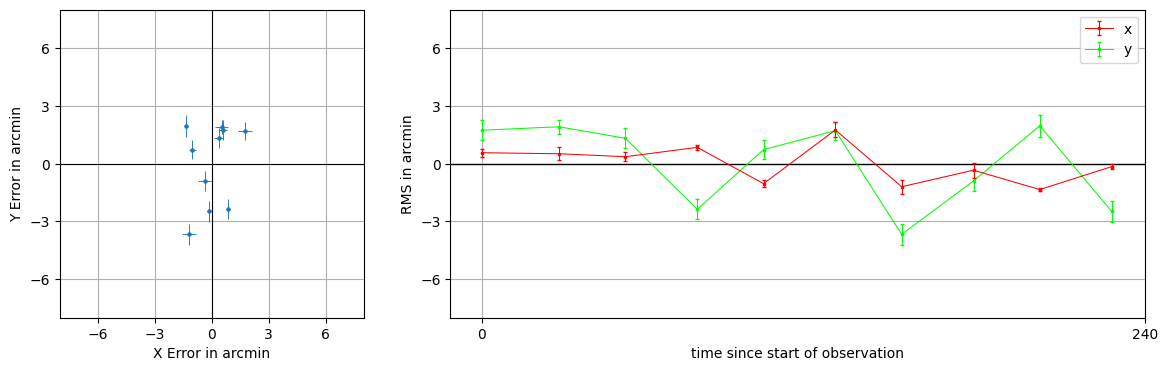

In [12]:
plt.close('all')
plt.figure(figsize=(14,4))
#plt.rcParams["font.family"] = "Times New Roman"

ax1=plt.subplot2grid((1, 3), (0, 0), colspan=1)

plt.scatter(pointing[:,0]*60 - np.mean(pointing[:,0]*60), pointing[:,1]*60 - np.mean(pointing[:,1]*60), color='C0', s=5, zorder=3)
plt.errorbar(pointing[:,0]*60 - np.mean(pointing[:,0]*60), pointing[:,1]*60 - np.mean(pointing[:,1]*60), xerr=pointing[:,3]*60, yerr=pointing[:,4]*60, linestyle='', linewidth=0.65, color='C0')


plt.axhline(color='k', linewidth=0.8, zorder=2)
plt.axvline(color='k', linewidth=0.8, zorder=2)
#plt.title('First Run', fontsize=15)
plt.grid()
plt.xticks(np.arange(-6,6.1,3))
plt.yticks(np.arange(-6,6.1,3))
plt.xlabel('X Error in arcmin')
plt.ylabel('Y Error in arcmin', rotation=90)
#plt.gca().set_aspect('equal')
plt.xlim(-8,8)
plt.ylim(-8,8)

ax2=plt.subplot2grid((1, 3), (0, 1), colspan=2)

plt.errorbar(times, pointing[:,0]*60 - np.mean(pointing[:,0]*60), yerr=pointing[:,3]*60, capsize=1.5, linestyle='-', color='r', linewidth = 0.75, label='x', marker='s', markersize=2, zorder=3)
plt.errorbar(times, pointing[:,1]*60 - np.mean(pointing[:,1]*60), yerr=pointing[:,4]*60, capsize=1.5, linestyle='-', color='lime', linewidth = 0.75, label='y', marker='s', markersize=2)

plt.ylabel('RMS in arcmin')
plt.xlabel('time since start of observation')

plt.ylim(-8,8)
#plt.xlim(-5,times[-1]-times[ref_idx]+15)
plt.yticks(np.arange(-6,6.1,3))
plt.xticks(np.arange(0,times[-1]-times[0]+15,240))
plt.axhline(color='k', linewidth=1)

plt.grid()
plt.legend()

plt.subplots_adjust(wspace=0.285)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


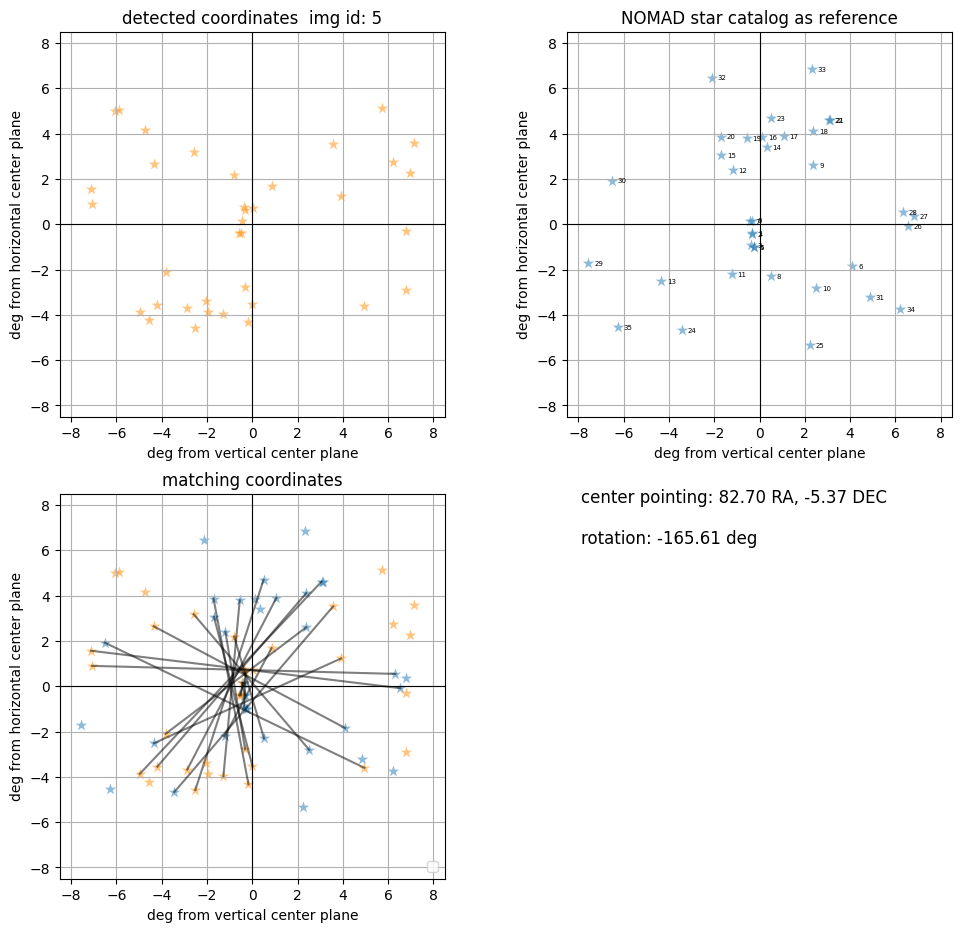

In [13]:
det_idx = 5

plt.close('all')
plt.figure(figsize=(12,11))


plt.subplot2grid((2, 2), (0, 0), colspan=1)
plt.scatter(coord_ang[det_idx][:,0], coord_ang[det_idx][:,1], color='darkorange', marker='*', alpha=0.5, s=75, linewidth=0)
plt.axhline(color='k', linewidth=0.8)
plt.axvline(color='k', linewidth=0.8)

plt.title('detected coordinates  img id: ' + str(det_idx))
plt.xlabel('deg from vertical center plane')
plt.ylabel('deg from horizontal center plane')
plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)
plt.xticks(np.arange(-8,8.1,2))
plt.yticks(np.arange(-8,8.1,2))
plt.grid()
plt.gca().set_aspect('equal')
##plt.gca().set_facecolor('k')


plt.subplot2grid((2, 2), (0, 1), colspan=1)
#plt.scatter(radec[ref_idx][:,0], radec[ref_idx][:,1], marker='*', alpha=0.5, s=75, linewidth=0)
plt.scatter(norm_star_coord[:,0], norm_star_coord[:,1], marker='*', alpha=0.5, s=75, linewidth=0)
plt.axhline(color='k', linewidth=0.8)
plt.axvline(color='k', linewidth=0.8)
#plot_triangle([tri1[0], tri1[1]])

for i in range(norm_star_coord.shape[0]):
    #plt.text(radec[ref_idx][i,0]+0.25, radec[ref_idx][i,1]-0.1, str(i), fontsize=5)
    plt.text(norm_star_coord[i,0]+0.25, norm_star_coord[i,1]-0.1, str(i), fontsize=5)

#plt.title('reference coordinates  img id: ' + str(ref_idx))
plt.title('NOMAD star catalog as reference')
plt.xlabel('deg from vertical center plane')
plt.ylabel('deg from horizontal center plane')
plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)
plt.xticks(np.arange(-8,8.1,2))
plt.yticks(np.arange(-8,8.1,2))
#plt.tick_params(labelleft = False)
plt.grid()
plt.gca().set_aspect('equal')


plt.subplot2grid((2, 2), (1, 0), colspan=1)

center = np.array([-2.25,-4])

plt.scatter(norm_star_coord[:,0], norm_star_coord[:,1], marker='*', s=75, alpha=0.5, linewidth=0)
plt.scatter(coord_ang[det_idx][:,0], coord_ang[det_idx][:,1], color='darkorange', marker='*', s=75, alpha=0.5, linewidth=0)
plt.axhline(color='k', linewidth=0.8)
plt.axvline(color='k', linewidth=0.8)
#plt.gca().add_patch(Rectangle((center[0]-.75,center[1]-.75), 1.5, 1.5, linewidth=0.8,linestyle='-',edgecolor='k',alpha=0.5,facecolor='none'))

for j in range(conn_stars[det_idx].shape[0]):
    plt.plot([conn_stars[det_idx][j][0], conn_stars[det_idx][j][2]],  [conn_stars[det_idx][j][1], conn_stars[det_idx][j][3]], 'k', alpha=0.5)
    #if j == 0: plt.scatter(conn_stars[det_idx-ref_idx][j][0], conn_stars[det_idx-ref_idx][j][1], color='lime', alpha=0.5, s=75, linewidth=0, zorder=2, marker='*', label='match')
    #else: plt.scatter(conn_stars[det_idx-ref_idx][j][0], conn_stars[det_idx-ref_idx][j][1], color='lime', alpha=0.5, s=75, linewidth=0, zorder=2, marker='*')

plt.text(14.5,6.3, 'center pointing: {0:.2f} RA, {1:.2f} DEC\n\nrotation: {2:.2f} deg'.format(pointing[det_idx][0], pointing[det_idx][1], pointing[det_idx][2]), fontsize=12)
plt.title('matching coordinates')
plt.xlabel('deg from vertical center plane')
plt.ylabel('deg from horizontal center plane')
plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)
plt.xticks(np.arange(-8,8.1,2))
plt.yticks(np.arange(-8,8.1,2))
#plt.tick_params(labelleft = False)
plt.legend(loc='lower right')
plt.grid()
plt.gca().set_aspect('equal')

plt.show()

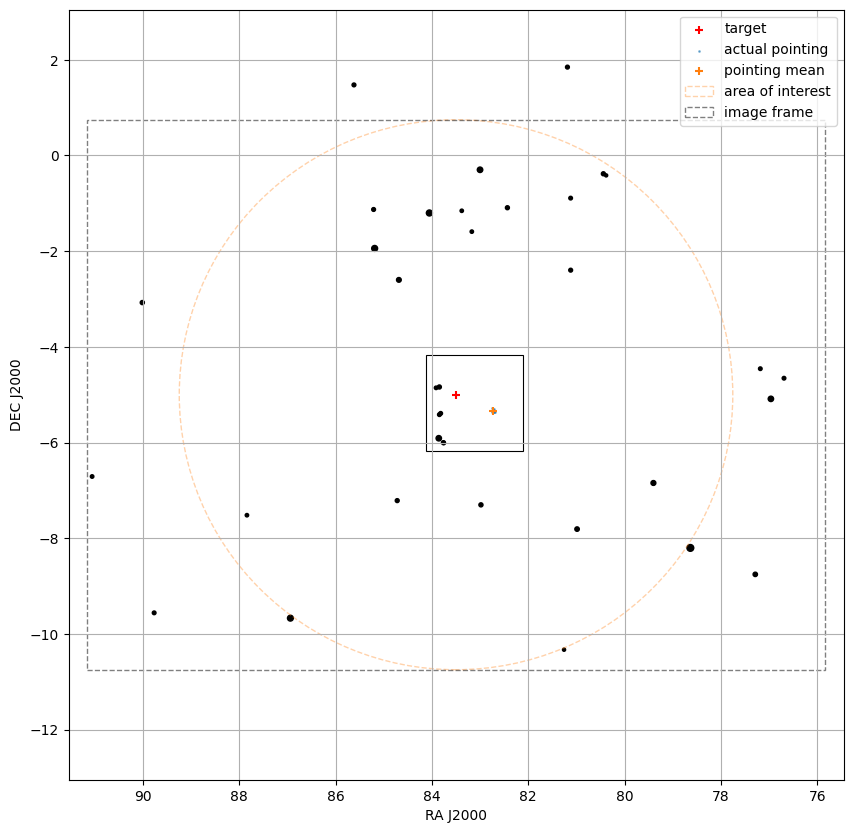

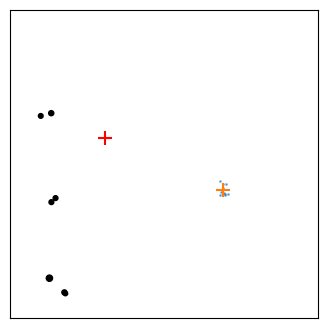

In [14]:

#norm_tgt = [-(i-tgt_coord[0]), j-tgt_coord[1]]

#angle = np.radians(rot_angle.mean(axis=0)*0)

#rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])

#p =  np.dot(rotation_matrix, displacement.T).T
#pt = np.array([tgt_coord[0]-p[:,0], tgt_coord[1]+p[:,1]])

center = ((tgt_coord[0]+pointing[:,0].mean())/2, (tgt_coord[1]+pointing[:,1].mean())/2)

fov = np.array([[i,j] for i, j in zip([0, 0, corr_images[0].shape[1], corr_images[0].shape[1]], [0, corr_images[0].shape[0], 0, corr_images[0].shape[0]])]).astype('int')

ra_lim, dec_lim = pxl_to_angle(fov)
ra_lim, dec_lim = ra_lim * 180/math.pi, dec_lim * 180/math.pi

#pt = np.array([tgt_coord[0]+p[:,0], tgt_coord[1]-p[:,1]]).T

plt.close('all')
fig, ax = plt.subplots(figsize=(10, 10))
#plt.grid()

plt.scatter(x['RAJ2000'], x['DEJ2000'], marker='o', color='k', s=norm_vmag*20+5)
plt.scatter(tgt_coord[0], tgt_coord[1], marker='+', color='r', label='target')
plt.scatter(pointing[:,0], pointing[:,1], color='C0', label='actual pointing', alpha=0.5, s=1)
#plt.scatter(tgt_coord[0]-displacement[:,0].mean(), tgt_coord[1]+displacement[:,1].mean(), marker='+', color='C2', label='pointing mean 1', alpha=1)
#plt.scatter(tgt_coord[0]-displacement1[:,0], tgt_coord[1]+displacement1[:,1], color='C0', alpha=0.5, s=1)
#plt.scatter(tgt_coord[0]-displacement1[:,0].mean(), tgt_coord[1]+displacement1[:,1].mean(), marker='+', color='C3', label='pointing mean 0', alpha=1)
plt.scatter(pointing[:,0].mean(), pointing[:,1].mean(), marker='+', color='C1', label='pointing mean', alpha=1)
#plt.scatter(pt[:,0], pt[:,1], color='C0', label='rot pointing (run 1)', alpha=1, s=100)
#plt.gca().add_patch(plt.Circle((tgt_coord[0], tgt_coord[1]), 10, linewidth=1, linestyle='--', edgecolor='r', alpha=0.5, facecolor='none', label='possible target area'))
plt.gca().add_patch(plt.Circle((tgt_coord[0], tgt_coord[1]), dec_lim[0], linewidth=1, linestyle='--', edgecolor='C1', alpha=0.35, facecolor='none', label='area of interest'))
plt.gca().add_patch(Rectangle((tgt_coord[0]-ra_lim[0], tgt_coord[1]-dec_lim[0]), -2*ra_lim[3], -2*dec_lim[3], linewidth=1,linestyle='--',edgecolor='k',alpha=0.5,facecolor='none', label='image frame', angle=0))
plt.gca().add_patch(Rectangle((center[0]+1, center[1]-1), -2, 2, linewidth=0.8,linestyle='-',edgecolor='k',alpha=1,facecolor='none'))

#plt.gca().add_patch(Rectangle((tgt_coord[0]+ra_lim[0], tgt_coord[1]+dec_lim[0]),2*ra_lim[3], 2*dec_lim[3],linewidth=1,linestyle='--',edgecolor='red',alpha=0.5,facecolor='none', label='image frame'))

ax.set_yticks(range(-90,91, 2))
ax.set_ylim(tgt_coord[1]+ra_lim[0]*1.05, tgt_coord[1]-ra_lim[0]*1.05)
ax.set_xticks(range(0,361, 2))
ax.set_xlim(tgt_coord[0]-ra_lim[0]*1.05, tgt_coord[0]+ra_lim[0]*1.05)

#plt.title('NOMAD catalog Vmag < {}'.format(Vmag_limit), pad=30)
#plt.title('NOMAD catalog Vmag < {}'.format(Vmag_limit), pad=30)
plt.xlabel('RA J2000')
plt.ylabel('DEC J2000')
plt.legend()
plt.grid()

plt.show()

fig, ax = plt.subplots(figsize=(4, 4))

plt.scatter(x['RAJ2000'], x['DEJ2000'], marker='o', color='k', s=norm_vmag*20+10)
plt.scatter(tgt_coord[0], tgt_coord[1], marker='+', color='r', label='target', s=100)
plt.scatter(pointing[:,0], pointing[:,1], color='C0', label='actual pointing', alpha=0.5, s=1)
#plt.scatter(tgt_coord[0]-displacement1[:,0], tgt_coord[1]+displacement1[:,1], color='C0', alpha=0.5, s=1)

plt.scatter(pointing[:,0].mean(), pointing[:,1].mean(), marker='+', color='C1', label='pointing mean', alpha=1, s=100)

plt.gca().set_aspect('equal')
ax.set_yticks(range(-90,91, 10))
ax.set_ylim(center[1]-1, center[1]+1)
ax.set_xticks(range(0,361, 10))
ax.set_xlim(center[0]+1, center[0]-1)

plt.show()
#print(pt)


#print(x.sort_values('Vmag'))
#print(((displacement.mean(axis=0))-(displacement1.mean(axis=0)))*60)

In [15]:
pointing[0,0:2]

array([82.71888807, -5.36573581])

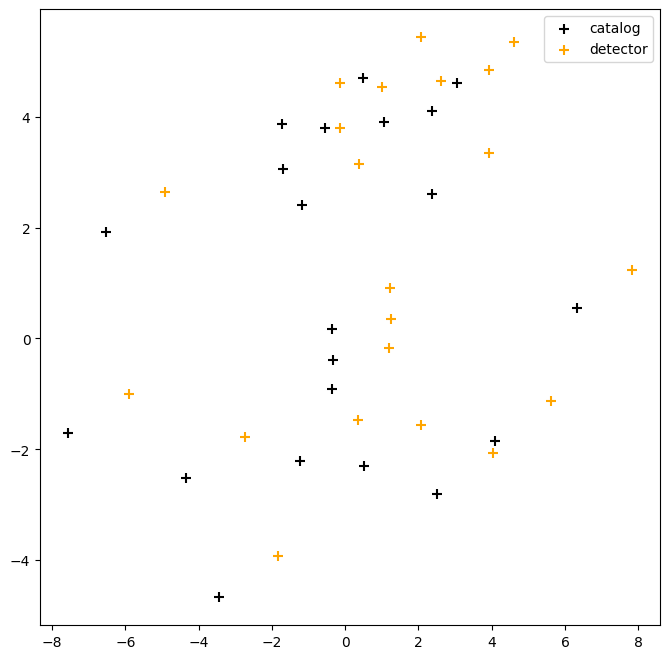

In [16]:
angle = np.radians(pointing[0,2])

rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])

a = -pointing[0,0:2]+tgt_coord
#a[0] *= -1

rotated_stars = np.dot(rotation_matrix, conn_stars[0][:,0:2].T).T + a

plt.close('all')
plt.figure(figsize=(8,8))

plt.scatter(conn_stars[0][:,2], conn_stars[0][:,3], marker='+', color='k', s=50, label='catalog')
plt.scatter(rotated_stars[:,0], rotated_stars[:,1], marker='+', color='orange', s=50, label='detector')

plt.legend()

plt.show()